# Chapter 3 - NLP Anomaly Explainability

Cleanlab, https://cleanlab.ai/, is an open-source library that helps quickly identify problems and outliers in messy and dirty real-world data, enabling more reliable machine learning and analytics by improving data quality for reliable machine learning applications. The first part of this notebook provides a walkthrough of NLP anomaly detection using the [Amazon Customer Reviews](https://doi.org/10.7910/DVN/W96OFO) dataset and Cleanlab. The second part of this notebook evaluates the interpretability using [SHapley Additive exPlanations (SHAP)](https://github.com/slundberg/shap).

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Install and Load the Libraries

In [2]:
# Install required packages

import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
# Load the essential libraries

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from platform import python_version

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

SEED = 42  

np.random.seed(SEED)
random.seed(SEED)

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.11.0
Python version: 3.9.10


## Prepare the Data

Load the text dataset. There are 5 classes for ratings. 

In [4]:
# Display full text

pd.set_option("display.max_colwidth", None)

In [5]:
df = pd.read_csv("export_food.csv")
df = df[['reviews','ratings']]
df['reviews'] = df['reviews'].str.strip()
df['ratings'].unique()

array([4, 5, 1, 2, 3])

Cleanlab requires zero-indexed target labels. Therefore, we will normalize the ratings column and assign to a new categorical_ratings column.

In [6]:
# Use LabelEncoder to normalize and encode target labels with value between 0 and n_classes-1.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['ratings'])
df['categorical_ratings'] = le.transform(df['ratings'])

df.head(5)

,reviews,ratings,categorical_ratings
0,"I’ve been ordering this product monthly for over a year. These past few shipments have been off, and the packaging is different. It is obvious they are from two different manufacturers. The full bottle is the imposter and has no pink ribbon on the label, the label photo is different, and if you look at the bottle, you can see on the back that the legitimate product has a 3% Juice Content label on the back up top, and the imposter has a 1% Juice Content. There are also other differences on the label. See Photos for comparison. Two different products, and the IMPOSTER is absolutely undrinkable and tastes nothing like the original product.I contacted Amazon and they are pulling this flavor, Red Grapefruit, off the shelf while they investigate this issue. They also issued me a full credit. I hope they can get this figured out because this is my favorite flavor and I drink it everyday.",4,3
1,"I used to drink these Sparkling Ice waters in all flavors every day. They all taste GREAT, my favorite was Black Raspberry. However, I just discovered that they contain sucralose which is just another harmful artificial sweetener. The only safe sweeteners are Stevia, Agave, and Raw Honey. I have stopped drinking/eating anything with harmful artificial sweeteners since they have been linked to many diseases, including dementia and the increase in Atzheimers disease patients.",5,4
2,"Update March 2019: I have been a regular subscriber of 3 cases a month of Sparkling Ice for a few years. I LOVED the stuff. It was plenty diabetic/keto-friendly with its 3% real juice and it tasted not merelt great, but REALISTIC. Then, sometime in the last year or so, I just stopped wanting to drink it as much. The flavor was no longer exciting. The mock mulled cider I made with it this Christmas fell flat. I thought I’d just lost my taste for it until I saw that another reviewer had noticed that the juice content went from 3% to 1%. I looked at my bottles and all the flavors indeed now say 1% juice.The company said it was to conform to its zero-sugar claim but I don’t believe it - 3% of 179mL (one serving) would be about 5g of juice, which would contain about half a gram of sugar, which can legally be labeled as 0 grams. They could have replaced the aromatics and maintained the flavor but that would probably have been more expensive than just using real juice.Now these drinks taste about the same as any other diet soda. The flavors are now flat instead of complex and realistic like they used to be.I AM CANCELLING MY SUBSCRIPTION FOR ALL THREE CASES PER MONTH. ARE YOU LISTENING, TALKING RAIN INC?I also intend to complain to Amazon about allowing Sparkling Ice to keep its past high ratings for what is no longer the same product. It is very misleading if reviews don’t all refer to the same thing being reviewed.Old review: Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling ciderBeing on a carb-restricted diet, one of the things I miss most is the taste of fruit, and especially the intense flavor of fruit juices. To my palate (accustomed as it is to most artificial sweeteners), Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling cider.Crisp Apple, Coconut Pineapple, and Pink Grapefruit are in my opinion, the most realistic flavors of Sparkling Ice.At $1 a bottle, it's not quite cheap but it is an affordable treat.Update: at Christmastime, I used Crisp Apple as a base for zero-carb mulled “cider.” Lacking proper mulling spices, a Constant Comment tea bag with its cinnamon/orange peel/clove flavoring did the trick nicely. A touch of malic acid restored the tanginess lost from heating the fizz (carbonic acid) out of it.",1,0
3,"I don't drink this myself, I buy it for my dad who I swear would drink it by the gallon if offered. He is diabetic and we have been trying to get him off of diet soda for a long time, this is better for him.I have no complaints about the product, I do wish ama

In [7]:
# Create a new dataset

raw_full_ds = df[['reviews','categorical_ratings']]
raw_full_ds.head(5)

,reviews,categorical_ratings
0,"I’ve been ordering this product monthly for over a year. These past few shipments have been off, and the packaging is different. It is obvious they are from two different manufacturers. The full bottle is the imposter and has no pink ribbon on the label, the label photo is different, and if you look at the bottle, you can see on the back that the legitimate product has a 3% Juice Content label on the back up top, and the imposter has a 1% Juice Content. There are also other differences on the label. See Photos for comparison. Two different products, and the IMPOSTER is absolutely undrinkable and tastes nothing like the original product.I contacted Amazon and they are pulling this flavor, Red Grapefruit, off the shelf while they investigate this issue. They also issued me a full credit. I hope they can get this figured out because this is my favorite flavor and I drink it everyday.",3
1,"I used to drink these Sparkling Ice waters in all flavors every day. They all taste GREAT, my favorite was Black Raspberry. However, I just discovered that they contain sucralose which is just another harmful artificial sweetener. The only safe sweeteners are Stevia, Agave, and Raw Honey. I have stopped drinking/eating anything with harmful artificial sweeteners since they have been linked to many diseases, including dementia and the increase in Atzheimers disease patients.",4
2,"Update March 2019: I have been a regular subscriber of 3 cases a month of Sparkling Ice for a few years. I LOVED the stuff. It was plenty diabetic/keto-friendly with its 3% real juice and it tasted not merelt great, but REALISTIC. Then, sometime in the last year or so, I just stopped wanting to drink it as much. The flavor was no longer exciting. The mock mulled cider I made with it this Christmas fell flat. I thought I’d just lost my taste for it until I saw that another reviewer had noticed that the juice content went from 3% to 1%. I looked at my bottles and all the flavors indeed now say 1% juice.The company said it was to conform to its zero-sugar claim but I don’t believe it - 3% of 179mL (one serving) would be about 5g of juice, which would contain about half a gram of sugar, which can legally be labeled as 0 grams. They could have replaced the aromatics and maintained the flavor but that would probably have been more expensive than just using real juice.Now these drinks taste about the same as any other diet soda. The flavors are now flat instead of complex and realistic like they used to be.I AM CANCELLING MY SUBSCRIPTION FOR ALL THREE CASES PER MONTH. ARE YOU LISTENING, TALKING RAIN INC?I also intend to complain to Amazon about allowing Sparkling Ice to keep its past high ratings for what is no longer the same product. It is very misleading if reviews don’t all refer to the same thing being reviewed.Old review: Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling ciderBeing on a carb-restricted diet, one of the things I miss most is the taste of fruit, and especially the intense flavor of fruit juices. To my palate (accustomed as it is to most artificial sweeteners), Crisp Apple Sparkling Ice tastes almost exactly like Martinelli's sparkling cider.Crisp Apple, Coconut Pineapple, and Pink Grapefruit are in my opinion, the most realistic flavors of Sparkling Ice.At $1 a bottle, it's not quite cheap but it is an affordable treat.Update: at Christmastime, I used Crisp Apple as a base for zero-carb mulled “cider.” Lacking proper mulling spices, a Constant Comment tea bag with its cinnamon/orange peel/clove flavoring did the trick nicely. A touch of malic acid restored the tanginess lost from heating the fizz (carbonic acid) out of it.",0
3,"I don't drink this myself, I buy it for my dad who I swear would drink it by the gallon if offered. He is diabetic and we have been trying to get him off of diet soda for a long time, this is better for him.I have no complaints about the product, I do wish amazon would do a

In [8]:
# Removes rows with NULL values

raw_full_ds = raw_full_ds.dropna()
raw_full_ds.isna()

,reviews,categorical_ratings
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
4995,False,False
4996,False,False
4997,False,False
4998,False,False


In [9]:
# Assign new target column

raw_full_texts = raw_full_ds['reviews']
full_labels = raw_full_ds['categorical_ratings']

In [10]:
# Set the number of categorical classes

num_classes = len(set(full_labels))  
print(f'Number of classes: {num_classes}')
print(f'Categorical classes: {set(full_labels)}')

Number of classes: 5
Categorical classes: {0, 1, 2, 3, 4}


In [11]:
print(f'Dataset shape: {raw_full_ds.shape}')
print(f'Dataset features: {raw_full_ds.columns}')

Dataset shape: (5000, 2)
Dataset features: Index(['reviews', 'categorical_ratings'], dtype='object')


In [12]:
# Convert DataFrame into NumPy array

raw_full_texts_arr = raw_full_texts.to_numpy(dtype=str)
raw_full_texts_arr

array(['I’ve been ordering this product monthly for over a year. These past few shipments have been off, and the packaging is different. It is obvious they are from two different manufacturers. The full bottle is the imposter and has no pink ribbon on the label, the label photo is different, and if you look at the bottle, you can see on the back that the legitimate product has a 3% Juice Content label on the back up top, and the imposter has a 1% Juice Content. There are also other differences on the label. See Photos for comparison. Two different products, and the IMPOSTER is absolutely undrinkable and tastes nothing like the original product.I contacted Amazon and they are pulling this flavor, Red Grapefruit, off the shelf while they investigate this issue. They also issued me a full credit. I hope they can get this figured out because this is my favorite flavor and I drink it everyday.',
       'I used to drink these Sparkling Ice waters in all flavors every day.  They all taste GRE

In [13]:
i = 4995
print(f"Example Label: {full_labels[i]+1}")
print(f"Example Text: {raw_full_texts[i]}")

Example Label: 4
Example Text: Great but cheaper at the store


In [14]:
# Function to clean the data by converting all characters to lowercase, removing HTML tags and punctuations

def preprocess_text(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

In [15]:
# Map text features to integer sequences

from tensorflow.keras import layers

tf.keras.utils.set_random_seed(SEED)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [16]:
# Apply preprocessing to the dataset

vectorize_layer.adapt(raw_full_texts_arr)
full_texts = vectorize_layer(raw_full_texts_arr)
full_texts = full_texts.numpy()

## Train a Simple Model

We are now ready to build a simple neural network for text classification using TensorFlow and Keras.

In [17]:
# Build a simple neural network for multiclass text classification

from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam


def get_net():
    net = tf.keras.Sequential(
        [tf.keras.Input(shape=(None,), dtype="int64"),
         layers.Embedding(max_features + 1, 16),
         layers.Dropout(0.2),
         layers.GlobalAveragePooling1D(),
         layers.Dropout(0.2),
         layers.Dense(num_classes),
         layers.Softmax()]
    )

    net.compile(
        optimizer="adam",
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=metrics.CategoricalAccuracy(),
    )
    return net

Adapt the neural network with SciKeras as some features from cleanlab must be scikit-learn compatible.

In [18]:
from scikeras.wrappers import KerasClassifier

# Try increase the number of training epochs for better results
model = KerasClassifier(get_net(), epochs=10)

Cleanlab requires predicted probabilities for each datapoint from a deep learning model. To avoid overfitting from these predicted probabilities, cleanlab uses out-of-sample predicted probabilities via held-out datapoints from training. Here, we are using K-fold cross validation to produce out-of-sample predicted probabilities where each training copy from a defined K copies is trained with different unseen data subsets.  

In [19]:
# Use K-fold cross-validation to avoid overfitting during training.

from sklearn.model_selection import cross_val_predict

# Try adjusting num_crossval_folds for better results
num_crossval_folds = 5 

pred_probs = cross_val_predict(
    model,
    full_texts,
    full_labels,
    cv=num_crossval_folds,
    method="predict_proba", 
)

INFO:tensorflow:Assets written to: ram://22c7d240ce5c4cd2acf03a8382fb6276/assets


INFO:tensorflow:Assets written to: ram://22c7d240ce5c4cd2acf03a8382fb6276/assets


Epoch 1/10
125/125 [==============================] - 16s 122ms/step - loss: 1.4304 - categorical_accuracy: 0.1065
Epoch 2/10
125/125 [==============================] - 8s 64ms/step - loss: 1.0661 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 4s 30ms/step - loss: 0.9969 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 3s 25ms/step - loss: 0.9910 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 14ms/step - loss: 0.9895 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 2s 15ms/step - loss: 0.9864 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 2s 16ms/step - loss: 0.9895 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 1s 11ms/step - loss: 0.9865 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 6ms/step 

INFO:tensorflow:Assets written to: ram://35ad695aaf0a4b66abb97635bec8d94a/assets


INFO:tensorflow:Assets written to: ram://35ad695aaf0a4b66abb97635bec8d94a/assets


Epoch 1/10
125/125 [==============================] - 13s 96ms/step - loss: 1.4300 - categorical_accuracy: 0.1032
Epoch 2/10
125/125 [==============================] - 8s 62ms/step - loss: 1.0663 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 4s 29ms/step - loss: 0.9956 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 3s 23ms/step - loss: 0.9900 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 18ms/step - loss: 0.9892 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 2s 12ms/step - loss: 0.9877 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 2s 14ms/step - loss: 0.9894 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 2s 13ms/step - loss: 0.9852 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 8ms/step -

INFO:tensorflow:Assets written to: ram://37f6f51f35434de8ace6789ab0e346f3/assets


INFO:tensorflow:Assets written to: ram://37f6f51f35434de8ace6789ab0e346f3/assets


Epoch 1/10
125/125 [==============================] - 11s 81ms/step - loss: 1.4278 - categorical_accuracy: 0.0728
Epoch 2/10
125/125 [==============================] - 6s 49ms/step - loss: 1.0637 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 4s 28ms/step - loss: 0.9959 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 3s 22ms/step - loss: 0.9885 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 13ms/step - loss: 0.9873 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 1s 9ms/step - loss: 0.9866 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.9883 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 1s 10ms/step - loss: 0.9839 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 5ms/step - l

INFO:tensorflow:Assets written to: ram://b0746e8c4dac444aac5bdc95ac3bb060/assets


INFO:tensorflow:Assets written to: ram://b0746e8c4dac444aac5bdc95ac3bb060/assets


Epoch 1/10
125/125 [==============================] - 10s 80ms/step - loss: 1.4247 - categorical_accuracy: 0.0650
Epoch 2/10
125/125 [==============================] - 5s 42ms/step - loss: 1.0625 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 4s 31ms/step - loss: 0.9964 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 2s 19ms/step - loss: 0.9883 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 15ms/step - loss: 0.9886 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 1s 11ms/step - loss: 0.9850 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.9839 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 0.9867 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 9ms/step - l

INFO:tensorflow:Assets written to: ram://13474fe51e32485ca9092750254c67cb/assets


INFO:tensorflow:Assets written to: ram://13474fe51e32485ca9092750254c67cb/assets


Epoch 1/10
125/125 [==============================] - 10s 79ms/step - loss: 1.4319 - categorical_accuracy: 0.0622
Epoch 2/10
125/125 [==============================] - 5s 38ms/step - loss: 1.0683 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 3s 26ms/step - loss: 0.9969 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 2s 19ms/step - loss: 0.9867 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 15ms/step - loss: 0.9879 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 0.9864 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 1s 9ms/step - loss: 0.9846 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 2s 12ms/step - loss: 0.9857 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 7ms/step - 

In [20]:
# Calculate log loss

from sklearn.metrics import log_loss

loss = log_loss(full_labels, pred_probs)  # score to evaluate probabilistic predictions, lower values are better
print(f"Cross-validated estimate of log loss: {loss:.3f}")

Cross-validated estimate of log loss: 0.981


## Find Label Anomaly

Cleanlab identifies label errors using self-confidence score ranking to measure label quality based on predicted probabilities.

In [21]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels=full_labels, pred_probs=pred_probs, return_indices_ranked_by="self_confidence"
)


In [22]:
# Top 10 potential label anomalies

print(
    f"Cleanlab identified {len(ranked_label_issues)} potential label errors.\n Indices of the top 10 most likely errors: \n {ranked_label_issues[:10]}"
)

Cleanlab identified 1577 potential label errors.
 Indices of the top 10 most likely errors: 
 [4270 4366 4327 4112 4872 4443 4496 4804 4009 4196]


In [23]:
#pd.set_option("display.max_colwidth", None)

# Function to view the top-ranked label issues found by cleanlab
def get_anomaly(index):
    return pd.DataFrame({"Reviews": raw_full_texts[index], "Labels": full_labels[index]+1}, [index])

In [24]:
get_anomaly(4270)

,Reviews,Labels
4270,Great price,2


In [25]:
get_anomaly(4112)

,Reviews,Labels
4112,I love the flavor!!!,2


## Train a Better Model

Manually inspecting and fixing potential label errors can be time-consuming. We can train a better model using Cleanlab to filter noisy data.

In [26]:
# Split the training and test dataset

from sklearn.model_selection import train_test_split

raw_train_texts, raw_test_texts, train_labels, test_labels = train_test_split(raw_full_texts, full_labels, test_size=0.2, random_state=42)

raw_train_texts.to_numpy(dtype=str)
raw_test_texts.to_numpy(dtype=str)

array(['Great soda alternative 👌',
       'Love love love these! So glad I can get my favorite flavor in a 12 pack. I can barely find one bottle in stores!',
       'Love this. Helps me keep hydrated.',
       'Love this drink. So great to get delivered at my door on a regular basis.',
       'I LOVE Sparkling ICE but I am upset with this purchase. The water is flat but still has good flavor. Today I looked at the bottle and noticed that the best buy date is 4/10/2020. I purchased this on 4/14/2020 which means I was sent this 4 days after the best buy date.',
       'I LOVE the Sparkling Ice brand of water.  It is so good.  Amazing flavor and goes down nice and smooth without too much carbonation.  This is the only kind of sparkling water I will buy.  I definitely recommend it.  I really like being able get a 12 pack at a time.  I also buy the Black Raspberry Sparkling Ice.  Both are super good and tasty :)',
       'Yeah, if you like apple flavor and/or beer, this would be the drink f

In [27]:
print(f'raw_train_texts shape: {raw_train_texts.shape}')
print(f'train_labels shape: {train_labels.shape}')
print(f'raw_test_texts shape: {raw_test_texts.shape}')
print(f'test_labels shape: {test_labels.shape}')

raw_train_texts shape: (4000,)
train_labels shape: (4000,)
raw_test_texts shape: (1000,)
test_labels shape: (1000,)


In [28]:
# Vectorize the raw text and convert to NumPy arrays

vectorize_layer.reset_state()
vectorize_layer.adapt(raw_train_texts)

train_texts = vectorize_layer(raw_train_texts)
test_texts = vectorize_layer(raw_test_texts)

train_texts = train_texts.numpy()
test_texts = test_texts.numpy()

In [29]:
# Start the training and evaluation

from sklearn.metrics import accuracy_score

model = KerasClassifier(get_net(), epochs=10)
model.fit(train_texts, train_labels)
preds = model.predict(test_texts)
acc_og = accuracy_score(test_labels, preds)

print(f'Test accuracy of original neural net: {acc_og}')

Epoch 1/10
125/125 [==============================] - 10s 74ms/step - loss: 1.4158 - categorical_accuracy: 0.0090
Epoch 2/10
125/125 [==============================] - 6s 45ms/step - loss: 1.0816 - categorical_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 3s 25ms/step - loss: 1.0130 - categorical_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 2s 17ms/step - loss: 1.0010 - categorical_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 2s 16ms/step - loss: 1.0000 - categorical_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 1s 11ms/step - loss: 0.9965 - categorical_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 1s 9ms/step - loss: 0.9943 - categorical_accuracy: 0.0000e+00
Epoch 8/10
125/125 [==============================] - 1s 8ms/step - loss: 0.9909 - categorical_accuracy: 0.0000e+00
Epoch 9/10
125/125 [==============================] - 1s 8ms/step - l

The CleanLearning wrapper class trains the original model with cross-validation to produce predicted probabilities for potential label errors. The noisy data with label errors are removed from the dataset before retraining the original model with the remaining clean data.

In [30]:
from cleanlab.classification import CleanLearning

model = KerasClassifier(get_net(), epochs=10)  
cl = CleanLearning(clf=model, seed=SEED)  

In [31]:
_ = cl.fit(train_texts, train_labels)

INFO:tensorflow:Assets written to: ram://09f8f9c972f245a99f80ef37871bed1f/assets


INFO:tensorflow:Assets written to: ram://09f8f9c972f245a99f80ef37871bed1f/assets


Epoch 1/10
100/100 [==============================] - 9s 81ms/step - loss: 1.4140 - categorical_accuracy: 0.0097
Epoch 2/10
100/100 [==============================] - 5s 55ms/step - loss: 1.0974 - categorical_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 3s 31ms/step - loss: 1.0152 - categorical_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 1.0023 - categorical_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 2s 19ms/step - loss: 0.9966 - categorical_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 1s 14ms/step - loss: 0.9902 - categorical_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.9952 - categorical_accuracy: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 1s 12ms/step - loss: 0.9948 - categorical_accuracy: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 1s 9ms/step - 

INFO:tensorflow:Assets written to: ram://6a11493395354c2d81cd8598dc38401a/assets


INFO:tensorflow:Assets written to: ram://6a11493395354c2d81cd8598dc38401a/assets


Epoch 1/10


100/100 [==============================] - 9s 78ms/step - loss: 1.4123 - categorical_accuracy: 0.0084
Epoch 2/10
100/100 [==============================] - 4s 41ms/step - loss: 1.0976 - categorical_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 4s 37ms/step - loss: 1.0185 - categorical_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 3s 26ms/step - loss: 1.0035 - categorical_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 2s 16ms/step - loss: 1.0004 - categorical_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.9983 - categorical_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 2s 15ms/step - loss: 0.9940 - categorical_accuracy: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 1s 10ms/step - loss: 0.9947 - categorical_accuracy: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 1s 12ms/step - loss: 0.99

INFO:tensorflow:Assets written to: ram://614dcdff2dda48db856d0c5f723e4136/assets


INFO:tensorflow:Assets written to: ram://614dcdff2dda48db856d0c5f723e4136/assets


Epoch 1/10
100/100 [==============================] - 9s 81ms/step - loss: 1.4132 - categorical_accuracy: 0.0100
Epoch 2/10
100/100 [==============================] - 5s 49ms/step - loss: 1.0974 - categorical_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 3s 33ms/step - loss: 1.0192 - categorical_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 3s 34ms/step - loss: 1.0046 - categorical_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 3s 27ms/step - loss: 1.0015 - categorical_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 2s 14ms/step - loss: 0.9932 - categorical_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.9945 - categorical_accuracy: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 1s 13ms/step - loss: 0.9906 - categorical_accuracy: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 1s 8ms/step - 

INFO:tensorflow:Assets written to: ram://1465f92aaa7d462d9ae10591cc837f46/assets


INFO:tensorflow:Assets written to: ram://1465f92aaa7d462d9ae10591cc837f46/assets


Epoch 1/10
100/100 [==============================] - 8s 80ms/step - loss: 1.4150 - categorical_accuracy: 0.0088
Epoch 2/10
100/100 [==============================] - 5s 54ms/step - loss: 1.0992 - categorical_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 3s 34ms/step - loss: 1.0213 - categorical_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 2s 25ms/step - loss: 1.0029 - categorical_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 2s 15ms/step - loss: 0.9992 - categorical_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.9987 - categorical_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 1s 8ms/step - loss: 0.9948 - categorical_accuracy: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 1s 9ms/step - loss: 0.9953 - categorical_accuracy: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 1s 5ms/step - lo

INFO:tensorflow:Assets written to: ram://c8966b5550c348b99d99af215852cab9/assets


INFO:tensorflow:Assets written to: ram://c8966b5550c348b99d99af215852cab9/assets


Epoch 1/10
100/100 [==============================] - 8s 79ms/step - loss: 1.4224 - categorical_accuracy: 0.0084
Epoch 2/10
100/100 [==============================] - 5s 48ms/step - loss: 1.1016 - categorical_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 3s 28ms/step - loss: 1.0168 - categorical_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 1.0013 - categorical_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 0.9985 - categorical_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 2s 16ms/step - loss: 0.9956 - categorical_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 2s 17ms/step - loss: 0.9950 - categorical_accuracy: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 1s 12ms/step - loss: 0.9973 - categorical_accuracy: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 1s 10ms/step -

88/88 [==============================] - 8s 77ms/step - loss: 2.2446 - categorical_accuracy: 0.0111
Epoch 2/10
88/88 [==============================] - 6s 65ms/step - loss: 1.3502 - categorical_accuracy: 0.0000e+00
Epoch 3/10
88/88 [==============================] - 4s 46ms/step - loss: 0.8902 - categorical_accuracy: 0.0000e+00
Epoch 4/10
88/88 [==============================] - 3s 33ms/step - loss: 0.7715 - categorical_accuracy: 0.0000e+00
Epoch 5/10
88/88 [==============================] - 2s 22ms/step - loss: 0.7150 - categorical_accuracy: 0.0000e+00
Epoch 6/10
88/88 [==============================] - 2s 17ms/step - loss: 0.6803 - categorical_accuracy: 7.1685e-04
Epoch 7/10
88/88 [==============================] - 1s 12ms/step - loss: 0.6654 - categorical_accuracy: 0.0025
Epoch 8/10
88/88 [==============================] - 1s 14ms/step - loss: 0.6436 - categorical_accuracy: 0.0025
Epoch 9/10
88/88 [==============================] - 1s 14ms/step - loss: 0.6261 - categorical_accuracy:

The Cleanlab-trained model behaves the same as the original model to make predictions. Test accuracy improved slightly after data cleaning for this example.

In [32]:
pred_labels = cl.predict(test_texts)
acc_cl = accuracy_score(test_labels, pred_labels)
print(f'Test accuracy of Cleanlab\'s neural net: {acc_cl}')

32/32 [==============================] - 0s 1ms/step
Test accuracy of Cleanlab's neural net: 0.696


## Evaluate NLP Explainability

NLP Explainability typically involves removing or masking random words from dataset. We will use [SHAP](https://github.com/slundberg/shap) to evaluate and visualize the feature attributions of individual classes for multiclass classification. We use BERT fine-tuned model to classify positive versus negative sentiment for the product reviews.

In [33]:
# Load the dataset

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import transformers
import shap

dataset = pd.read_csv('export_food.csv')
data = pd.DataFrame({'text':dataset['reviews'],'sentiment':dataset['ratings']})

In [34]:
# Load a fine-tuned NLP transformer model

import transformers

model = transformers.pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english',
    top_k=None
)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_25']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Pass the transformers pipeline object directly to shap.Explainer

explainer = shap.Explainer(model)

In [36]:
# Pass a list of text to explain the classifications. For example, 4112 is one of the predicted label errors found by Cleanlab.

shap_values = explainer(df['reviews'][4111:4113])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Partition explainer: 3it [01:49, 54.62s/it]               


## Visualize Feature Attributions

Hover over an output class to see the explanation for a predicted output class. The base value represents the model outputs when the entire input text is removed or masked. The $f_{outputclass}(inputs)$ is the output for the full original input. SHAP values shows the impact of unmasking each word deviates from the base value.

In [37]:
shap.plots.text(shap_values)

In [38]:
# Slicing a single output class. For example, POSITIVE only

shap.plots.text(shap_values[:, :, "POSITIVE"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [39]:
# Slicing a single output class. For example, NEGATIVE only

shap.plots.text(shap_values[:, :, "NEGATIVE"])

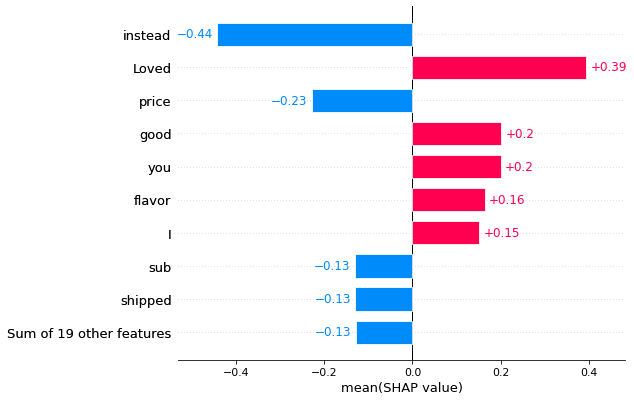

In [40]:
# Top words impacting a specific class

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0))

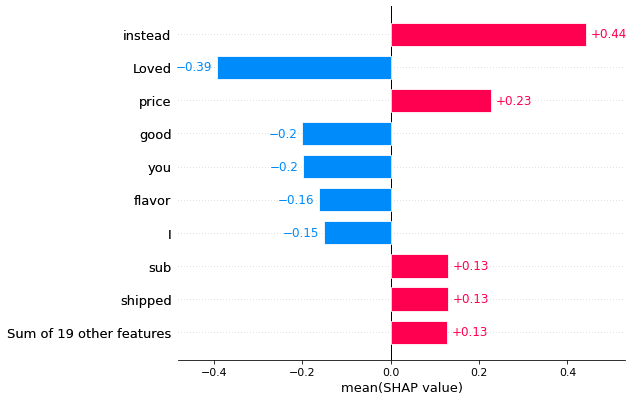

In [41]:
# Top words impacting a specific class

shap.plots.bar(shap_values[:,:,"NEGATIVE"].mean(0))

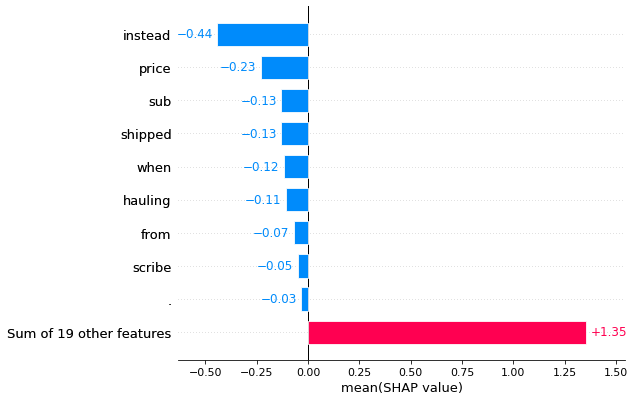

In [42]:
# Sort the bar chart in descending order

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0), order=shap.Explanation.argsort)

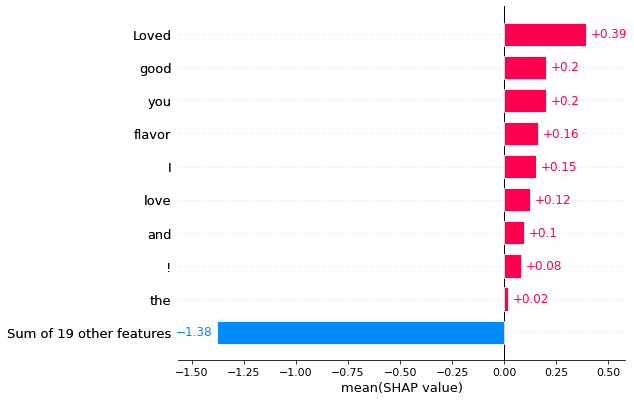

In [43]:
# Sort the bar chart in ascending order

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0), order=shap.Explanation.argsort.flip)

This concludes the NLP anomaly explainability for multiclass text classification example. You successfully identified label anomalies using a text dataset and explained the words that contributed to the predicted class using SHAP.